В данном задании вам может помочь питон-бук по RNN из вашего основного курса : https://github.com/ml-mipt/ml-mipt/blob/master/week12_seq2seq_and_embeddings/rnn_pytorch.ipynb.

В этом домашнем задании мы будем генерировать тексты из высказываний Ницше при помощи рекуррентных сетей. 
Наша модель будет основываться на символах и генерировать посимвольно.

In [1]:
import numpy as np
import random
import sys
import io
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

Скачиваем данные. Корпус состоит из высказываний Ницше, разделеных переносом строки.

In [2]:
#!wget 'https://s3.amazonaws.com/text-datasets/nietzsche.txt'

Откроем данные. Мы будем работать с символами. Посмотрим сколько уникальных символов есть в корпусе.
Также поставим каждому символу в соответствие число, чтобы далее работать с числами.

In [82]:
with io.open('nietzsche.txt', encoding='utf-8') as f:
    text = f.read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

corpus length: 600893
total chars: 57


Составьте датасет. Мы будем по maxlen предыдущих символов предсказывать один следующий символ, таким образом решаем задачу классификации на `len(chars)` классов. Датасет должен состоять из пар вида [maxlen символов]-[следующий символ]. <br>

Для этого есть несколько вариантов: <br>

1) Разбить весь текст на высказывания. Внутри каждого высказывания пройтись окошком размера maxlen символов и взять следующий после окошка символ как ответ. Проходиться по высказыванию можно с некоторым шагом step, то есть сдвиг окошек взять равным step. В данном случае придется завести специальный символ для паддинга (например, #), которого нет в словаре. Этот символ будет использоваться для увеличения размера высказываний. Например, предложение *"I like NLP"* превратится в *"###I like NLP###"*. Сколько таких символов добавлять - гиперпараметр.
Не забудьте добавить новый символ в словарь и поставить ему в соответствие число.<br>

2) Не разбивать на высказывания, а работать с полным текстом. По нему аналогично пройтись окошками и составить датасет. В таком случае одно окно может содержать конец одного высказывания и начало другого (разделенных \n), но зато не нужно делать padding.

`prev_chars` - массив из предыдущих maxlen символов.  <br>
`next_chars` - массив из следующего символа.

In [4]:
text = text.replace('\n', ' ')

In [5]:
maxlen = 40 # you can change this number
step = 2 # you can change this number

PAD = '#'
chars = sorted(list(set(text)) + [PAD])
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

current_phrase = ''
phrases = []
for s in text:
    current_phrase += s
    if s in ['.', '!', '?']:
        if len(current_phrase) != 0:
            phrases.append(PAD * step + current_phrase.strip() + PAD * step)
        current_phrase = ''    

prev_chars = []
next_char = []

for p in phrases:
    for i in range(0, len(p) - maxlen - 1, step):
        prev_chars.append(p[i:i + maxlen])
        next_char.append(p[i + maxlen])

print('count of elements in dataset:', len(prev_chars))

total chars: 57
count of elements in dataset: 241687


Теперь нужно полученный датасет перевести из текстового формата в векторный.
Тут тоже есть несколько вариантов: <br>

1) Перевести каждый символ в число и каждому числу поставить в соответствие one-hot вектор. В таком случае prev_chars превратиться в массив размера (count_elements, maxlen, len(chars)). 
next_char лучше не переводить в one-hot, а оставить в численном формате. Это связано с тем, что PyTorch при подсчете лосса принимает в аргументах метки в виде чисел, а не one-hot векторов. То есть next_char должен иметь размер (count_elements,)<br>

2) Перевести каждый символ в число. Тогда prev_chars превратиться в массив размера (count_elements, maxlen). next_char здесь обрабатывается так же как и в пункте 1). После этого внутри модели будем строить обучаемые эмбеддинги с помощью специального слоя (об этом далее), чтобы перевести эти числа в вектора (не пугайтесть, это не сложно). 

In [6]:
x = np.array([[char_indices[c] for c in p] for p in prev_chars])
y = np.array([char_indices[c] for c in next_char])

Разобьем полученные данные на обучение и валидацию.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.05)

Приступим к написанию модели.

In [8]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim 
import time

Наша модель будет состоять из одного или нескольких RNN. На вход модель принимает предыдущие maxlen символов и на выходе возвращает вероятности быть следующим символом для каждого символа из словаря. <br>
Заметим, что если ранее вы кодировали символы one-hot векторами, то эти one-hot вектора уже можно подавать на вход рекуррентной сети. Если же вы кодировали каждый символ числом, то такое подавать на вход RNN плохо (вы задали порядок на символах). Чтобы избежать этой проблемы используется обучаемый эмбеддинг слой (`nn.Embedding`), который каждому числу сопоставит некоторое обучаемое векторное представление.  <br>

*Напоминание из лекции про* ***Embedding слой***: <br>
Пусть у нас есть vocab_len токенов в словаре и каждому токену мы хотим поставить в соответствие вектор-представление размера emb_size. Тогда заведем обучаемую матрицу W размера (vocab_len, emb_size). i-ая строка такой матрицы как раз и является эмбеддингом токена под индексом i. Таким образом, Embedding слой принимает на вход индекс токена из словаря и просто берет строку из матрицы W с таким индексом. <br>
Остается понять, почему такое преобразование не испортит подсчет градиентов. Для этого нужно понять, что Embedding слой эквивалентен следующему : возьмем на вход индекс токена, переведем этот индекс в one-hot вектор и умножем полученный вектор на матрицу W. Немного подумав, можно понять, что это то же самое, что и просто взятие определенной строки из матрицы W. То есть Embedding слой эквивалентен обычному полносвязному слою без смещения, поэтому такое преобразование является дифференцируемым.<br><br>

После того, как получены векторные представления для каждого символа, их можно подать на вход рекуррентной сети. 
Для этого вам могут понадобиться следующие слои: `nn.RNN`, `nn.GRU`, `nn.LSTM`. Каждый из этих слоев в конструкторе принимает 3 важных параметра : `input_size`, `hidden_size`, `num_layers`. <br>
`input_size` - размерность входного эмбеддинга для токена (vocab_len в случае использования one-hot векторов и emb_size в случае использования Embedding слоя). <br>
`hidden_size` - размерность скрытого состояния $h$.<br>
`num_layers` - количество таких rnn-ок, настаканных друг на друга. Например, num_layers = 2 означает, что первая rnn принимает на вход эмбеддинги символов и на каждом этапе возвращает скрытое состояние, а вторая rnn принимает на вход скрытые состояния первой rnn и возвращает свои скрытые состояния. Не берите num_layers слишком большой, 1-3 достаточно.<br>

Метод forward у данных слоев принимает всю входную последовательность размера (maxlen, batch_size, emb_size) для всех элементов в батче и применяет рекуррентную ячейку последовательно сначала к первым символам, потом ко вторым и так далее. Кроме того, метод принимает начальную инициализацию для скрытого состояния. Для `nn.RNN` и `nn.GRU` начальная инициализация - один вектор размера (num_layers, batch_size, hidden_size), а для `nn.LSTM` 2 вектора размера (num_layers, batch_size, hidden_size) так как LSTM имеет 2 состояния. Обычно в качестве начальной инициализации берут нулевой тензор. Возвращает данный метод всю последовательность hidden_state-ов на каждом этапе времени и hidden_state в последний этап времени (у LSTM еще и cell_state в последний этап времени).<br>
Заметим еще раз, входная последовательность должна иметь размер (maxlen, batch_size, emb_size), поэтому вам скорей всего нужно будет сделать `.traspose(0, 1)`, что поменяет местами первые 2 размерности. Это связано с тем, что один объект из выборки имеет размерность (maxlen, emb_size) и весь батч будет иметь размерность (batch_size, maxlen, emb_size).<br>


После того как получены скрытые состояния, из них можно получить вероятности. Для этого можно, например, взять последнее скрытое состояние (можно использовать не только последнее) и применить к нему полносвязный слой, который вернет нужное количество чисел. Заметим, что лучше возвращать не сами вероятности, а логиты (то, что получается до применения softmax), не применяя softmax в конце, так как это будет удобно при подсчете лосса далее. <br>


Попробуйте несколько разных rnn-ок (разные типы слоев или разные гиперпараметры) и разных сеток, для получения вероятностей по скрытым состояниям.<br>

In [9]:
class Model(nn.Module):
    def __init__(self, input_size=200, hidden_dim=128,
                 num_layers=1, out_size=len(chars),
                 rnn_type=nn.RNN, device='cpu'):

        super(Model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.out_size = out_size
        self.device = device
        self.rnn_type = rnn_type
        
        self.embeddings = nn.Embedding(self.out_size, self.input_size) 
        self.rnn = self.rnn_type(input_size=self.input_size,
                         hidden_size=self.hidden_dim,
                         num_layers=self.num_layers,
                         batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_size)
        
    def forward(self, x):
        x = self.embeddings(x)
        x, states = self.rnn(x)
        logits = self.fc(x[:, -1, :].squeeze(0))
        return logits

Инициализируем модель.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
model_rnn = Model(device=device, rnn_type=nn.RNN).to(device)

Напишем функцию для подсчета лосса. Здесь мы по сути решаем задачу классификации на vocab_len=len(chars) классов, поэтому в качестве лосса возьмем cross-entropy (neg log-likelihood). Заметим, что функция `F.cross_entropy` принимает на вход именно логиты, а не вероятности, именно поэтому лучше, чтобы модель возвращала логиты, не применяя softmax.<br>

*Замечание*<br>
Если вы при составлении датасета используете паддинг, то добавленные при помощи него символы не должны ничего вносить в лосс. То есть на тех местах, где истинный символ является специальным символом для паддинга, мы не обращаем внимания на предсказания. Иначе нейросеть может научиться всегда предсказывать этот специальный символ (так как он часто встречается и это будет минимизировать лосс). Есть несколько вариантов сделать это. Например, можно считать лосс так : <br>
`criterion = nn.CrossEntropyLoss(ignore_index=pad_ix, size_average=True)
criterion(logits, y_batch)`<br>
вместо <br>
`F.cross_entropy(logits, y_batch)`<br>
Здесь pad_ix - число, которое мы поставили в соответствие специальному символу для паддинга ранее : Например, `char_indices['#']` если вы используете '#' в качестве символа для паддинга.

In [12]:
def compute_loss(model, X_batch, y_batch, pad_ix=char_indices[PAD]):
    logits = model(X_batch)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_ix, size_average=True)
    # rewrite it in case you use padding
    return criterion(logits, y_batch)

Напишем функцию генерации батчей.

In [13]:
def iterate_minibatches(X, y, batch_size, shuffle=True):
    if shuffle:
        indices = np.random.permutation(np.arange(len(X)))
    else:
        indices = np.arange(len(X))
        
    for start in range(0, len(indices), batch_size):
        ix = indices[start: start + batch_size]
        yield torch.LongTensor(X[ix]).to(device), \
              torch.LongTensor(y[ix]).to(device)

Обучение. Это может занять какое-то время. Сэкономить время поможет https://colab.research.google.com или запускаться на ночь.

In [14]:
def train(model, num_epochs = 10, batch_size = 32, lr=1e-4):
    opt = optim.Adam(model.parameters(), lr=lr)
    train_loss = []
    val_accuracy = []
    val_loss = []

    for epoch in range(num_epochs):
        # На каждой эпохе делаем полный проход по данным
        start_time = time.time()
        model.train(True) # устанавливаем поведение dropout / batch_norm  в обучение
        for X_batch, y_batch in iterate_minibatches(X_train, y_train,
                                                    batch_size, True):
            # Обучаемся на батче
            loss = compute_loss(model, X_batch, y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss.append(loss.item())

        # Полный проход по валидации
        # устанавливаем поведение dropout / batch_norm  в тестирование
        model.train(False)
        for X_batch, y_batch in iterate_minibatches(X_val, y_val,
                                                    batch_size, False):
            logits = model(X_batch)
            loss = nn.CrossEntropyLoss(ignore_index=char_indices[PAD],
                                       size_average=True)(
                                       logits, y_batch) 
            # находим индексы максимумов
            y_pred = logits.max(1)[1]
            val_accuracy.append((y_batch == y_pred).type(
                                torch.FloatTensor).mean().item())
            val_loss.append(loss.item())

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))
    return model, train_loss, val_accuracy, val_loss

In [15]:
num_epochs = 300
batch_size = 512

In [16]:
# model_rnn, train_loss_rnn, val_acc_rnn, _ = train(model_rnn,
#                                                num_epochs=num_epochs,
#                                                batch_size=batch_size)
# torch.save(model_rnn.state_dict(), 'model_rnn')

results = [(1.322897, 56.56)]  #результат последней оценки на валидации
model_rnn.load_state_dict(torch.load('model_rnn'))

In [17]:
model_gru = Model(device=device, rnn_type=nn.GRU).to(device)
# model_gru, train_loss_gru, val_acc_gru, _ = train(model_gru,
#                                                num_epochs=num_epochs,
#                                                batch_size=batch_size)
# torch.save(model_gru.state_dict(), 'model_gru')
results.append((1.154201, 57.80))
model_gru.load_state_dict(torch.load('model_gru'))

In [18]:
model_lstm = Model(device=device, rnn_type=nn.LSTM).to(device)
# model_lstm, train_loss_lstm, val_acc_lstm, val_loss_lstm = train(model_lstm,
#                                                   num_epochs=num_epochs,
#                                                   batch_size=batch_size)
# torch.save(model_lstm.state_dict(), 'model_lstm')
results.append((1.136434, 58.02))
model_lstm.load_state_dict(torch.load('model_lstm'))

In [22]:
model_lstm2 = Model(device=device, rnn_type=nn.LSTM, num_layers=2).to(device)
model_lstm2, train_loss_lstm, val_acc_lstm, val_loss_lstm = train(model_lstm2,
                                                  num_epochs=300,
                                                  batch_size=batch_size, lr=5e-5)
torch.save(model_lstm2.state_dict(), 'model_lstm2')

Epoch 1 of 300 took 7.328s
  training loss (in-iteration): 	3.197992
  validation accuracy: 			17.64 %
Epoch 2 of 300 took 7.120s
  training loss (in-iteration): 	2.768501
  validation accuracy: 			27.26 %
Epoch 3 of 300 took 7.249s
  training loss (in-iteration): 	2.564013
  validation accuracy: 			30.12 %
Epoch 4 of 300 took 7.060s
  training loss (in-iteration): 	2.443618
  validation accuracy: 			31.21 %
Epoch 5 of 300 took 7.124s
  training loss (in-iteration): 	2.360804
  validation accuracy: 			32.32 %
Epoch 6 of 300 took 7.213s
  training loss (in-iteration): 	2.295135
  validation accuracy: 			34.25 %
Epoch 7 of 300 took 7.224s
  training loss (in-iteration): 	2.239451
  validation accuracy: 			36.17 %
Epoch 8 of 300 took 7.118s
  training loss (in-iteration): 	2.190694
  validation accuracy: 			36.97 %
Epoch 9 of 300 took 7.337s
  training loss (in-iteration): 	2.147395
  validation accuracy: 			38.35 %
Epoch 10 of 300 took 7.032s
  training loss (in-iteration): 	2.109532
  v

Epoch 80 of 300 took 5.680s
  training loss (in-iteration): 	1.466709
  validation accuracy: 			54.19 %
Epoch 81 of 300 took 5.717s
  training loss (in-iteration): 	1.463721
  validation accuracy: 			54.23 %
Epoch 82 of 300 took 5.699s
  training loss (in-iteration): 	1.460642
  validation accuracy: 			54.39 %
Epoch 83 of 300 took 5.705s
  training loss (in-iteration): 	1.457110
  validation accuracy: 			54.35 %
Epoch 84 of 300 took 5.666s
  training loss (in-iteration): 	1.454434
  validation accuracy: 			54.42 %
Epoch 85 of 300 took 5.736s
  training loss (in-iteration): 	1.451082
  validation accuracy: 			54.42 %
Epoch 86 of 300 took 5.722s
  training loss (in-iteration): 	1.447922
  validation accuracy: 			54.61 %
Epoch 87 of 300 took 5.682s
  training loss (in-iteration): 	1.444920
  validation accuracy: 			54.57 %
Epoch 88 of 300 took 5.726s
  training loss (in-iteration): 	1.441958
  validation accuracy: 			54.64 %
Epoch 89 of 300 took 5.680s
  training loss (in-iteration): 	1.4

Epoch 159 of 300 took 5.694s
  training loss (in-iteration): 	1.291712
  validation accuracy: 			57.02 %
Epoch 160 of 300 took 5.670s
  training loss (in-iteration): 	1.290289
  validation accuracy: 			57.05 %
Epoch 161 of 300 took 5.687s
  training loss (in-iteration): 	1.288582
  validation accuracy: 			57.06 %
Epoch 162 of 300 took 5.741s
  training loss (in-iteration): 	1.287033
  validation accuracy: 			57.23 %
Epoch 163 of 300 took 5.768s
  training loss (in-iteration): 	1.285391
  validation accuracy: 			57.06 %
Epoch 164 of 300 took 5.774s
  training loss (in-iteration): 	1.283960
  validation accuracy: 			57.22 %
Epoch 165 of 300 took 5.692s
  training loss (in-iteration): 	1.282621
  validation accuracy: 			56.99 %
Epoch 166 of 300 took 5.728s
  training loss (in-iteration): 	1.280766
  validation accuracy: 			57.15 %
Epoch 167 of 300 took 5.651s
  training loss (in-iteration): 	1.279384
  validation accuracy: 			57.20 %
Epoch 168 of 300 took 5.756s
  training loss (in-iterat

Epoch 238 of 300 took 7.910s
  training loss (in-iteration): 	1.186244
  validation accuracy: 			57.54 %
Epoch 239 of 300 took 7.902s
  training loss (in-iteration): 	1.185283
  validation accuracy: 			57.80 %
Epoch 240 of 300 took 7.623s
  training loss (in-iteration): 	1.184103
  validation accuracy: 			57.67 %
Epoch 241 of 300 took 7.853s
  training loss (in-iteration): 	1.182776
  validation accuracy: 			57.74 %
Epoch 242 of 300 took 7.582s
  training loss (in-iteration): 	1.181573
  validation accuracy: 			57.68 %
Epoch 243 of 300 took 7.797s
  training loss (in-iteration): 	1.180588
  validation accuracy: 			57.82 %
Epoch 244 of 300 took 7.659s
  training loss (in-iteration): 	1.179306
  validation accuracy: 			57.78 %
Epoch 245 of 300 took 7.804s
  training loss (in-iteration): 	1.178649
  validation accuracy: 			57.74 %
Epoch 246 of 300 took 7.918s
  training loss (in-iteration): 	1.177295
  validation accuracy: 			57.69 %
Epoch 247 of 300 took 7.822s
  training loss (in-iterat

In [24]:
results.append((1.120251, 57.92))

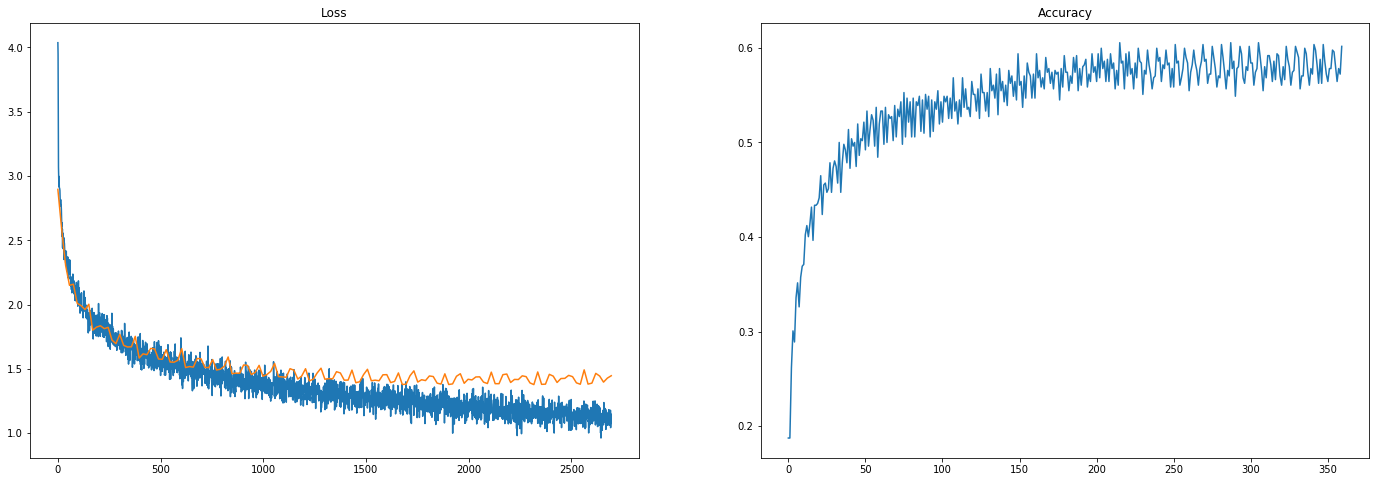

In [27]:
plt.figure(figsize=(24, 8))
plt.subplot(121)
plt.plot(train_loss_lstm[::50], label='train')
plt.plot(np.linspace(0, len(train_loss_lstm[::50]),
                     len(val_loss_lstm[::50])),
                     val_loss_lstm[::50], label='validation')
plt.title('Loss')
plt.subplot(122)
plt.plot(val_acc_lstm[::20], label='validation')
plt.title('Accuracy')
plt.show();

Лосс и accuracy на валидации выходят на плато, значит мы остановились не слишком рано. 

Сравним разные типы RNN-ок:

In [32]:
pd.DataFrame(results, columns=['Train loss', 'Accuracy'],
             index=['RNN', 'GRU', 'LSTM', 'LSTM2'])

,Train loss,Accuracy
RNN,1.322897,56.56
GRU,1.154201,57.80
LSTM,1.136434,58.02
LSTM2,1.120251,57.92


Чем сложнее модель (просто `RNN` -> `GRU` -> `LSTM`), тем лучше получаются результаты

Напишем функцию, которая по началу высказывания будет генерировать следующие length_to_predict символов.
Для этого нужно сначала входной текст привести в формату, который принимает на вход модель. После этого предсказать первый символ. Предсказаный символ следует добавить в конец текста и полученный текст опять привести к нужному формату. После этого можно предсказать следующий символ и так далее.<br>

*Замечания* <br>
1) Модель принимает объекты батчами, поэтому если вы будете подавать ей один элемент она будет ругаться. Один элемент нужно подавать как батч размера 1. <br>
2) Для получения предсказания в виде индекса следующего символа нужно найти аргмаксимум по логитам. В этом вам поможет logits.max(dim), который принимает в аргументах размерность dim по которой искать максимумы и возвращает сразу 2 тензора - максимумы и индексы максимумов.<br>

In [33]:
def predict(model, text, length_to_predict):
    with torch.no_grad():
        input_text = text[-maxlen:]
        if len(input_text) < maxlen:
            input_text = [PAD] * (maxlen - len(input_text)) + input_text
        x = np.array([char_indices[c] for c in input_text])
        x = torch.LongTensor(x).to(device).unsqueeze(0)
        result = []
        for i in range(length_to_predict):
            logits = model(x)
            next_char = torch.argmax(logits)
            result.append(next_char.item())
            x = torch.cat([x,
                torch.LongTensor([next_char]).unsqueeze(0).to(device)], 1)[:, 1:]
        return ''.join([indices_char[i] for i in result])

Посмотрим, что предсказывает модель. Не пугайтесь если будет не много смысла в самих высказываниях, это все-таки char-based модель, однако локальный смысл (связанные 3ки-5ки слов) должен присутствовать.

In [34]:
model_list = [model_rnn, model_gru, model_lstm, model_lstm2]
names_list = ['RNN', 'GRU', 'LSTM', 'LSTM2']
test_text = "be no mistake about it: it was neither more nor less " + \
        "than a pig, and she felt that it would be quit"

In [35]:
for m, name in zip(model_list, names_list):
    print(f'{name}: {test_text}[{predict(m, test_text, 400)}]')
    print()

RNN: be no mistake about it: it was neither more nor less than a pig, and she felt that it would be quit[e the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sens]

GRU: be no mistake about it: it was neither more nor less than a pig, and she felt that it would be quit[e becomes and the struggle in the same distrust of the same distrust of the same distrust of the same distrust of the same distrust of the same distrust of the same distrust of the same distrust of the same distrust of the same distrust of the same distrust of the same distrust of the same distrust of the same distrust of the same distrust of the same distrust of the same distrust of 

Видим, что один и тот же кусок текста начинает постоянно повторяться (кроме сгенерированного двухслойной `LSTM`). Чтобы этого избежать, будем брать не максимум логитов, а случайный символ с распределением вероятностей, равным `Softmax(logits)` (тогда символ с максимальной вероятностью всё равно будет выбираться чаще всего, но не постоянно)

In [85]:
def predict_randomized(model, text, length_to_predict):
    with torch.no_grad():
        input_text = text[-maxlen:]
        if len(input_text) < maxlen:
            input_text = [PAD] * (maxlen - len(input_text)) + input_text
        x = np.array([char_indices[c] for c in input_text])
        x = torch.LongTensor(x).to(device).unsqueeze(0)
        result = []
        for i in range(length_to_predict):
            logits = model(x)
            next_char = np.random.choice(np.arange(len(char_indices)),
                                p=F.softmax(logits, -1).cpu().numpy())
            result.append(next_char)
            x = torch.cat([x,
                torch.LongTensor([next_char]).unsqueeze(0).to(device)], 1)[:, 1:]
        return ''.join([indices_char[i] for i in result])

In [37]:
for m, name in zip(model_list, names_list):
    print(f'{name}: {test_text}[{predict_randomized(m, test_text, 400)}]')
    print()

RNN: be no mistake about it: it was neither more nor less than a pig, and she felt that it would be quit[e rimalt, sensitive in his tening a colds ideary i something place antil for all new point," priflere supletamy, into the propped of alrict, with that we perto.ted also it of the incrifices wea our volugning the necessity, "which unspirated also regreing be diskinm man" of more "foreing feel be obvereme of the barred with it exuad seeice; and a say: the act: at god, self-revere of through this pre]

GRU: be no mistake about it: it was neither more nor less than a pig, and she felt that it would be quit[e assumen that say some of us: he one partion of his least recognized and it assumedanted in the instinct can years and develop of functions of the behings the herdory and gask, himself.aly sinces, sake of mankind of all geners and yet the same time it often to men.oned himself no different strangest with them of the overturds for greatories, having a pease.tional wrong in which, from

Заметим, что текст, сгенерированный 2-слойной LSTM от такого метода только пострадал.

## Бонус



Ранее мы обучили модель по maxlen предыдущим символам предсказывать один следующий. Именно поэтому для предсказания нескольких следующих символов мы сначала предсказывали один символ, потом добавляли его к входным данным и уже потом предсказывали следуюший. Получается, что для такого предсказания нам нужно прогнать нейросеть столько раз, сколько символов мы хотим предсказывать.<br>

Напишите нейросеть, использующую RNN, которая не будет иметь такой проблемы. Она должна обучиться на *каждом шаге* rnn предсказывать следующее слово. Для этого вам понадобится к каждому скрытому состоянию вашей rnn применить некоторую классификационную нейросеть, аналогичную классификационной нейросети ранее. Каждая такая сеть будет пытаться предсказать следующее слово на своем этапе. На каждом этапе времени вы получите свое предсказание вероятности для следующего символа, после этого усредните лосс по этим предсказаниям. <br>

**Замечания** <br>
1) Проследите, что вы действительно предсказываете следующий символ, а не текущий. Проще всего поступить так : 
пусть на вход приходит последовательность $x_1, x_2, ..., x_{maxlen}$ и вы хотите на каждом этапе времени t по символам $x_1, ..., x_{t - 1}$ предсказывать символ $x_t$. Для этого на вход нужно подать последовательность $BOS, x_1, x_2..., x_{maxlen - 1}$ и в качестве таргетов взять последовательность $x_1, x_2, ..., x_{maxlen}$. BOS (begin of sentence) - специальный символ начала предложения (любой новый символ, которого нет в словаре). 

2) При обучении вы подаете на вход истинные символы и предсказываете следующий, а при тестировании у вас этих истинных символов нет. Поэтому при тестировании вам нужно поступить так :
Сначала берем на вход $BOS$, применяем рекуррентную ячейку и предсказываем вероятности быть следующим символом для каждого символа из словаря. Находим символ с максимальной вероятностью, обозначим его $x_1$. Теперь подаем символ $x_1$ на вход рекуррентной ячейке и предсказываем вероятности для следующих символов. Заметим, что если вы имеете некоторые начальные символы $x_1, .., x_k$, которые нужно продолжить, то сначала на вход будут подаваться истинные символы, а потом, когда те закончатся, предсказанные символы.<br>

<br>


На рисунке можно увидеть пример такой сети. При обучении мы подаем на вход истинные символы и на этапе времени $i - 1$ предсказываем вероятности $\widehat{y^{(i)}}$ быть следующим ($i$ - ым) словом для всех слов из словаря. 
<br>Лоссом здесь будет $\frac{1}{maxlen} \sum\limits_i^{maxlen} cross\_entropy(\widehat{y^{(i)}}, y^{(i)})$, где  $y^{(i)}$  - истинный индекс $i$-ого слова.

При тестировании на вход рекуррентной ячейке подается не настоящий символ, а символ, который имел наибольшую вероятность быть следующим на предыдущем шаге.

![img](https://i.ibb.co/BnftCLh/Screenshot-2019-05-03-at-21-45-01.png)

![imh](https://i.ibb.co/rwHyYsK/Screenshot-2019-05-03-at-21-44-53.png)

Для выполнения этого задания вам понадобятся `nn.RNNCell`, `nn.LSTMCell` или `nn.GRUCell`. <br>
Как с ними работать вы разбирались на семинаре основного курса : https://github.com/ml-mipt/ml-mipt/blob/master/week12_seq2seq_and_embeddings/rnn_pytorch.ipynb

Придётся немного поменять предобработку данных: добавить токены начала и конца последовательности + в батч будет попадать только сама последовательность индексов (содержащая в себе и X, и target).

In [57]:
maxlen = 40
step = 20
PAD = '#'
BOS = '[BOS]'
EOS = '[EOS]'
chars = sorted(list(set(text)) + [PAD, BOS, EOS])
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

current_phrase = ''
phrases = []
for s in text:
    current_phrase += s
    if s in ['.', '!', '?']:
        if len(current_phrase) != 0:
            phrases.append([BOS] + [c for c in current_phrase.strip()] + [EOS])
        current_phrase = ''    

char_seqs = []
for p in phrases:
    for i in range(0, len(p) - maxlen, step):
        char_seqs.append(p[i:i + maxlen])

print('count of elements in dataset:', len(char_seqs))

x = np.array([[char_indices[c] for c in p] for p in char_seqs])
X_train, X_val = train_test_split(x, test_size=0.05)

total chars: 59
count of elements in dataset: 25306


In [58]:
class CellModel(nn.Module):
    def __init__(self, input_size=200, hidden_dim=128,
                 out_size=len(chars),
                 cell_type=nn.LSTMCell, device='cpu'):
        super(CellModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.out_size = out_size
        self.device = device
        self.cell_type = cell_type
        
        self.embeddings = nn.Embedding(self.out_size, self.input_size) 
        self.rnn_cell = self.cell_type(input_size=self.input_size,
                         hidden_size=self.hidden_dim)
        self.fc = nn.Linear(hidden_dim, out_size)
        
    def forward(self, x, h=None, c=None):
        x = self.embeddings(x)
        hidden_states = []
        hc = (h, c)
        if h is None or c is None:
            hc = None
        for i in range(x.shape[1]):
            h, c = self.rnn_cell(x[:, i, :], hc)
            hc = (h, c)
            hidden_states.append(h.unsqueeze(1))
        logits = self.fc(torch.cat(hidden_states, 1))
        return logits, h, c

In [72]:
train_loss = []
val_accuracy = []
val_loss = []

In [73]:
def compute_loss_seq(model, X_batch, pad_ix=char_indices[PAD]):
    logits, _, _ = model(X_batch[:, :-1])
    return F.cross_entropy(logits.reshape(-1, logits.shape[-1]),
                           X_batch[:, 1:].reshape(-1), ignore_index=pad_ix)

def iterate_minibatches_seq(X, batch_size, shuffle=True):
    if shuffle:
        indices = np.random.permutation(np.arange(len(X)))
    else:
        indices = np.arange(len(X))
        
    for start in range(0, len(indices), batch_size):
        ix = indices[start: start + batch_size]
        yield torch.LongTensor(X[ix]).to(device)

def train_cell(model, num_epochs=10, batch_size=32, lr=1e-4):
    opt = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train(True)
        for X_batch in iterate_minibatches_seq(X_train, batch_size, True):
            loss = compute_loss_seq(model, X_batch, pad_ix=char_indices[PAD])
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss.append(loss.item())

        model.train(False)
        for X_batch in iterate_minibatches_seq(X_val, batch_size, False):
            logits, _, _ = model(X_batch[:, :-1])
            loss = F.cross_entropy(logits.reshape(-1, logits.shape[-1]),
                                   X_batch[:, 1:].reshape(-1),
                                   ignore_index=char_indices[PAD]) 
            y_pred = logits.max(-1)[1]
            val_accuracy.append((X_batch[:, 1:] == y_pred).type(torch.FloatTensor).mean().item())
            val_loss.append(loss.item())

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))
    return model, train_loss, val_accuracy, val_loss

In [75]:
model_cell = CellModel(device=device).to(device)
model_cell, train_loss_cell, val_acc_cell, val_loss_cell = train_cell(
                            model_cell, num_epochs=200, batch_size=256, lr=5e-4)
torch.save(model_cell.state_dict(), 'model_cell')
# model_lstm.load_state_dict(torch.load('model_cell'))

Epoch 1 of 200 took 1.921s
  training loss (in-iteration): 	2.924449
  validation accuracy: 			31.35 %
Epoch 2 of 200 took 1.929s
  training loss (in-iteration): 	2.305787
  validation accuracy: 			36.17 %
Epoch 3 of 200 took 1.943s
  training loss (in-iteration): 	2.143227
  validation accuracy: 			39.57 %
Epoch 4 of 200 took 1.994s
  training loss (in-iteration): 	2.037093
  validation accuracy: 			41.85 %
Epoch 5 of 200 took 1.988s
  training loss (in-iteration): 	1.959373
  validation accuracy: 			43.66 %
Epoch 6 of 200 took 1.953s
  training loss (in-iteration): 	1.899085
  validation accuracy: 			45.11 %
Epoch 7 of 200 took 1.945s
  training loss (in-iteration): 	1.849669
  validation accuracy: 			46.21 %
Epoch 8 of 200 took 1.984s
  training loss (in-iteration): 	1.808286
  validation accuracy: 			47.33 %
Epoch 9 of 200 took 2.047s
  training loss (in-iteration): 	1.772831
  validation accuracy: 			48.14 %
Epoch 10 of 200 took 2.017s
  training loss (in-iteration): 	1.742087
  v

Epoch 80 of 200 took 2.333s
  training loss (in-iteration): 	1.316548
  validation accuracy: 			58.88 %
Epoch 81 of 200 took 2.325s
  training loss (in-iteration): 	1.315317
  validation accuracy: 			59.00 %
Epoch 82 of 200 took 2.304s
  training loss (in-iteration): 	1.313697
  validation accuracy: 			59.01 %
Epoch 83 of 200 took 2.261s
  training loss (in-iteration): 	1.312354
  validation accuracy: 			59.11 %
Epoch 84 of 200 took 2.296s
  training loss (in-iteration): 	1.310563
  validation accuracy: 			59.07 %
Epoch 85 of 200 took 2.224s
  training loss (in-iteration): 	1.309429
  validation accuracy: 			59.03 %
Epoch 86 of 200 took 2.338s
  training loss (in-iteration): 	1.307895
  validation accuracy: 			59.13 %
Epoch 87 of 200 took 2.284s
  training loss (in-iteration): 	1.306736
  validation accuracy: 			59.18 %
Epoch 88 of 200 took 2.261s
  training loss (in-iteration): 	1.305188
  validation accuracy: 			59.11 %
Epoch 89 of 200 took 2.356s
  training loss (in-iteration): 	1.3

Epoch 159 of 200 took 2.345s
  training loss (in-iteration): 	1.244523
  validation accuracy: 			60.35 %
Epoch 160 of 200 took 2.313s
  training loss (in-iteration): 	1.244094
  validation accuracy: 			60.25 %
Epoch 161 of 200 took 2.326s
  training loss (in-iteration): 	1.243372
  validation accuracy: 			60.27 %
Epoch 162 of 200 took 2.360s
  training loss (in-iteration): 	1.242756
  validation accuracy: 			60.24 %
Epoch 163 of 200 took 2.344s
  training loss (in-iteration): 	1.242407
  validation accuracy: 			60.27 %
Epoch 164 of 200 took 2.306s
  training loss (in-iteration): 	1.241580
  validation accuracy: 			60.44 %
Epoch 165 of 200 took 2.388s
  training loss (in-iteration): 	1.241140
  validation accuracy: 			60.33 %
Epoch 166 of 200 took 2.265s
  training loss (in-iteration): 	1.240591
  validation accuracy: 			60.40 %
Epoch 167 of 200 took 2.374s
  training loss (in-iteration): 	1.239977
  validation accuracy: 			60.45 %
Epoch 168 of 200 took 2.266s
  training loss (in-iterat

In [77]:
results.append((1.224228, 60.50))

Лучший результат по accuracy, средний - по лоссу:

In [79]:
pd.DataFrame(results, columns=['Train loss', 'Accuracy'],
             index=['RNN', 'GRU', 'LSTM', 'LSTM2', 'New model'])

,Train loss,Accuracy
RNN,1.322897,56.56
GRU,1.154201,57.80
LSTM,1.136434,58.02
LSTM2,1.120251,57.92
New model,1.224228,60.50


Перепишем `predict` с учётом новой модели:

In [80]:
def predict_sequential_randomized(model, text, length_to_predict):
    with torch.no_grad():
        x = np.array([char_indices[BOS]]+ [char_indices[c] for c in text])
        x = torch.LongTensor(x).to(device).unsqueeze(0)
        result = []
        hc = None
        for i in range(length_to_predict):
            logits, h, c = model(x, hc)
            hc = (h, c)
            logits = logits[:, -1, :].squeeze(0)
            next_char = np.random.choice(len(char_indices),
                                p=F.softmax(logits, -1).cpu().numpy())
            result.append(next_char)
            x = torch.LongTensor([next_char]).to(device).unsqueeze(0)
        return ''.join([indices_char[i] for i in result])

In [89]:
print(f'{test_text}[{predict_sequential_randomized(model_cell, test_text, 400)}]')

be no mistake about it: it was neither more nor less than a pig, and she felt that it would be quit[s--than only from from us !head! were philosophy) is irronace of them.-to the genius mysting! of results, we fair pro form of the command.er.an), and one still concesural can possible-stryple to be hand when the only equally indiscreed that account, to be devally and before the original pointionem, is tepits to light even up some, has been the same time allows such a consequent, as in order to uta]
